In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2

from barbar import Bar

import utils.imageTransformation as it

## Dataset Import

In [2]:
IMAGE_FOLDER = "Dataset/images/" 
meta_Dataframe = pd.read_csv("Dataset/info.csv")

In [3]:
print(meta_Dataframe.head())

             Namefile  Species   bbxmin   bbymin   bbxmax   bbymax
0    Abyssinian_1.jpg      cat      333       72      425      158
1   Abyssinian_10.jpg      cat       72      105      288      291
2  Abyssinian_100.jpg      cat      151       71      335      267
3  Abyssinian_101.jpg      cat       54       36      319      235
4  Abyssinian_102.jpg      cat       23       27      325      320


In [4]:
def getinfo(meta_Dataframe, imgind):
    return meta_Dataframe.iloc[imgind, 0], meta_Dataframe.iloc[imgind, 1], np.array([meta_Dataframe.iloc[imgind, 2],meta_Dataframe.iloc[imgind, 3],meta_Dataframe.iloc[imgind, 4],meta_Dataframe.iloc[imgind, 5]])

def show_bndbox(image, label, bndboxinfo, color = (0,255,0)):
    left = bndboxinfo[0]
    top = bndboxinfo[1]
    right = bndboxinfo[2]
    bottom = bndboxinfo[3]
    imgHeight, imgWidth, _ = image.shape
    thick = int((imgHeight + imgWidth) // 900)
    
    cv2.rectangle(image,(left, top), (right, bottom), color, thick)
    cv2.putText(image, label, (left, top - 12), 0, 1e-3 * imgHeight, color, thick//3)
    
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    #plt.imshow(image)
    plt.show()

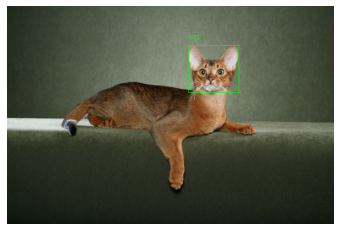

In [5]:
filename, label, bndboxinfo = getinfo(meta_Dataframe, 0)
path_file=IMAGE_FOLDER + filename

image = cv2.imread(path_file)
show_bndbox(image, label, bndboxinfo)

## Dataset

In [6]:
class RaceDogsCatsBNBDataset(Dataset):
    def __init__(self, csv_file, image_dir, transforms=None):
        self.info = pd.read_csv(csv_file)
        self.images = image_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        filename, label, bndbox = getinfo(self.info, idx)

        image = cv2.imread(self.images + filename)
        
        sample = {'image': image, 'bndbox': bndbox, 'label': label}
        

        if self.transforms:
            sample = self.transforms(sample)
        
        return sample

## Transform Compose

In [7]:
composed = transforms.Compose([it.Rescale((256,256)),
                               it.ToTensor()])

In [8]:
transformed_dataset = RaceDogsCatsBNBDataset(csv_file = "Dataset/info.csv",
                                             image_dir = IMAGE_FOLDER,
                                             transforms = composed)

dataloader = DataLoader(transformed_dataset, batch_size = 4, shuffle = True, num_workers = 4)

In [9]:
train_size = int(0.7 * len(transformed_dataset))
test_size = len(transformed_dataset) - train_size
Train_Dataset, Test_Dataset = torch.utils.data.random_split(transformed_dataset, [train_size, test_size])

In [10]:
Train_Loader = DataLoader(Train_Dataset, batch_size = 4, shuffle = True, num_workers = 4)
Test_Loader = DataLoader(Test_Dataset, batch_size = 4, shuffle = False, num_workers = 4)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    
    # Copie des poids du réseau
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
                dataload = Train_Loader
            else:
                model.eval()
                dataload = Test_Loader
                
            running_loss = 0.0
            running_corrects = 0
            
            for idx, (image, bndbox, label) in enumerate(Bar(dataload)):
                inputs = inputs.to(device)
                bndbox = bndbox.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enable(phase = 'train'):
                    outpurs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    #Calcul de la fonction de perte
                    loss = criterion(outputs, labels)
                    
                    #Backpropagation
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)        
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model